In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os
import copy
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
%matplotlib inline

# Load the datasets and dataloaders

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64
EPOCHS = 30

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


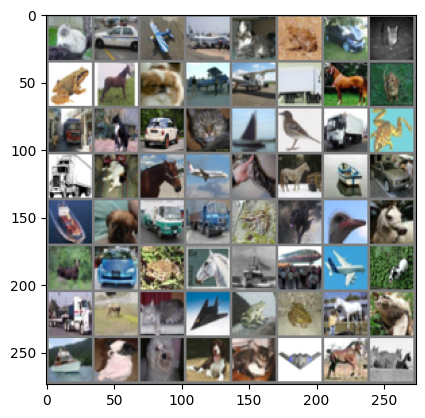

cat   car   plane plane cat   frog  car   cat   frog  horse dog   plane plane truck horse dog   truck cat   car   cat   ship  bird  truck frog  truck cat   horse plane cat   horse ship  car   ship  dog   truck truck frog  dog   bird  horse deer  car   frog  horse ship  plane plane dog   truck deer  cat   plane frog  frog  horse frog  ship  dog   dog   dog   cat   plane horse cat  


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [28]:
import torch.optim as optim

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using {device} device")

Using cuda device


# Teacher Model

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class TeacherNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, bias=True)
        self.pool = nn.MaxPool2d(2, stride=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, bias=True)
        self.pool = nn.MaxPool2d(2, stride=1)
        self.batchnorm2 = nn.BatchNorm2d(64)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.15)

        self.dense1 = nn.Linear(43264, 64)
        self.dense2 = nn.Linear(64, 32)
        self.dense3 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool(out)
        out = self.batchnorm1(out)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.batchnorm2(out)
        
        out = self.flatten(out)
        out = self.dropout(out)

        out = self.dense1(out)
        out = F.relu(out)
        out = self.dense2(out)
        out = F.relu(out)
        out = self.dense3(out)
        
        return out

In [30]:
teacher_model = TeacherNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher_model.parameters(), lr=0.01, momentum=0.9)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


In [31]:
teacher_accs = []
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = teacher_model(inputs)
        
        teacher_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        teacher_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += teacher_loss.item()
        running_corrects += torch.sum(preds == labels.data)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = running_corrects.double() / len(trainloader.dataset)
    teacher_accs.append(epoch_acc)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - - Train Loss: {epoch_loss: .4f}, Train Acc: {epoch_acc: .2f}")

print('Finished Training')

torch.save(teacher_model.state_dict(), "teachermodelnet.pth")


Epoch [1/30] - - Train Loss:  0.0222, Train Acc:  0.50
Epoch [2/30] - - Train Loss:  0.0176, Train Acc:  0.61
Epoch [3/30] - - Train Loss:  0.0155, Train Acc:  0.66
Epoch [4/30] - - Train Loss:  0.0138, Train Acc:  0.70
Epoch [5/30] - - Train Loss:  0.0123, Train Acc:  0.73
Epoch [6/30] - - Train Loss:  0.0111, Train Acc:  0.76
Epoch [7/30] - - Train Loss:  0.0100, Train Acc:  0.78
Epoch [8/30] - - Train Loss:  0.0088, Train Acc:  0.80
Epoch [9/30] - - Train Loss:  0.0080, Train Acc:  0.82
Epoch [10/30] - - Train Loss:  0.0073, Train Acc:  0.84
Epoch [11/30] - - Train Loss:  0.0064, Train Acc:  0.86
Epoch [12/30] - - Train Loss:  0.0059, Train Acc:  0.87
Epoch [13/30] - - Train Loss:  0.0054, Train Acc:  0.88
Epoch [14/30] - - Train Loss:  0.0050, Train Acc:  0.89
Epoch [15/30] - - Train Loss:  0.0045, Train Acc:  0.90
Epoch [16/30] - - Train Loss:  0.0041, Train Acc:  0.91
Epoch [17/30] - - Train Loss:  0.0038, Train Acc:  0.92
Epoch [18/30] - - Train Loss:  0.0035, Train Acc:  0.92
E

# Student model with KD

In [32]:
class StudentNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, bias=True)
        self.pool = nn.MaxPool2d(2, stride=1)
        #self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, bias=True)
        self.pool = nn.MaxPool2d(2, stride=1)
        #self.batchnorm2 = nn.BatchNorm2d(64)

        self.flatten = nn.Flatten()
        #self.dropout = nn.Dropout(p=0.15)

        self.dense1 = nn.Linear(43264, 16)
        self.dense2 = nn.Linear(16, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool(out)
        #out = self.batchnorm1(out)
        out = self.conv2(out)
        out = self.pool(out)
        # out = self.batchnorm2(out)
        
        out = self.flatten(out)
        #out = self.dropout(out)
        
        out = self.dense1(out)
        out = F.relu(out)
        out = self.dense2(out)
        out = F.relu(out)

        return out

# KD Loss

In [33]:
student_model = StudentNet().to(device)
teacher_model = TeacherNet().to(device)
teacher_model.load_state_dict(torch.load("teachermodelnet.pth"))

# distillation
def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss()(F.log_softmax((y/T)+1,dim=1), F.softmax((teacher_scores/T)+1,dim=1)) * (T*T + alpha) + F.cross_entropy((y+1),labels) * (1.-alpha)

# val los
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student_model.parameters(), lr=0.01, momentum=0.9)

In [34]:
T = 1.0
alpha = 0.5
KD_student_accs = []
KD_std_val_accs = []
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        teacher_output = teacher_model(inputs).detach()
        student_outputs = student_model(inputs)
        student_loss = distillation(student_outputs, labels, teacher_output, T, alpha)
        _, student_preds = torch.max(student_outputs, 1)
        student_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += student_loss.item()
        running_corrects += torch.sum(student_preds == labels.data)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = running_corrects.double() / len(trainloader.dataset)
    KD_student_accs.append(epoch_acc)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - - Train Loss: {epoch_loss: .4f}, Train Acc: {epoch_acc: .2f}")
    
    test_loss = 0
    test_correct = 0
    total = 0
    student_model.eval()
    with torch.no_grad():

        for inputs, labels in testloader:
            # Move the inputs and labels to the device (GPU) if available
            inputs, labels = inputs.to(device), labels.to(device)
            # Compute the model's predictions
            teacher_output = teacher_model(inputs).detach()
            outputs = student_model(inputs)

            # Compute the testing loss
            loss = distillation(outputs, labels, teacher_output, T, alpha)
            test_loss += loss.item() * labels.size(0)

            # Compute the testing accuracy
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Compute the average testing loss and accuracy
        test_loss /= total
        test_acc = 100 * test_correct / total
        KD_std_val_accs.append(test_acc)
        # Print the epoch number, training loss and accuracy, and testing loss and accuracy
        print(
            f"Epoch [{epoch+1}/{EPOCHS}] - - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print('Finished Training')

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch [1/30] - - Train Loss:  0.0157, Train Acc:  0.44
Epoch [1/30] - - Test Loss: 0.8260, Test Acc: 52.98%
Epoch [2/30] - - Train Loss:  0.0120, Train Acc:  0.58
Epoch [2/30] - - Test Loss: 0.7480, Test Acc: 58.51%
Epoch [3/30] - - Train Loss:  0.0109, Train Acc:  0.62
Epoch [3/30] - - Test Loss: 0.6911, Test Acc: 62.22%
Epoch [4/30] - - Train Loss:  0.0103, Train Acc:  0.64
Epoch [4/30] - - Test Loss: 0.6875, Test Acc: 61.88%
Epoch [5/30] - - Train Loss:  0.0098, Train Acc:  0.66
Epoch [5/30] - - Test Loss: 0.6910, Test Acc: 61.88%
Epoch [6/30] - - Train Loss:  0.0092, Train Acc:  0.68
Epoch [6/30] - - Test Loss: 0.6818, Test Acc: 62.85%
Epoch [7/30] - - Train Loss:  0.0088, Train Acc:  0.70
Epoch [7/30] - - Test Loss: 0.7042, Test Acc: 62.91%
Epoch [8/30] - - Train Loss:  0.0082, Train Acc:  0.71
Epoch [8/30] - - Test Loss: 0.7705, Test Acc: 59.88%
Epoch [9/30] - - Train Loss:  0.0078, Train Acc:  0.73
Epoch [9/30] - - Test Loss: 0.7166, Test Acc: 62.80%
Epoch [10/30] - - Train Loss

# Student with no KD

In [35]:
class StandardNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, bias=True)
        self.pool = nn.MaxPool2d(2, stride=1)
        #self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, bias=True)
        self.pool = nn.MaxPool2d(2, stride=1)
        #self.batchnorm2 = nn.BatchNorm2d(64)

        self.flatten = nn.Flatten()
        #self.dropout = nn.Dropout(p=0.15)

        self.dense1 = nn.Linear(43264, 16)
        self.dense2 = nn.Linear(16, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool(out)
        #out = self.batchnorm1(out)
        out = self.conv2(out)
        out = self.pool(out)
        # out = self.batchnorm2(out)
        
        out = self.flatten(out)
        #out = self.dropout(out)
        
        out = self.dense1(out)
        out = F.relu(out)
        out = self.dense2(out)
        out = F.relu(out)

        return out

In [36]:
standard_model = StandardNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(standard_model.parameters(), lr=0.01, momentum=0.9)

In [37]:
student_accs = []
std_val_accs = []
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = standard_model(inputs)
        standard_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        standard_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += standard_loss.item()
        running_corrects += torch.sum(preds == labels.data)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = running_corrects.double() / len(trainloader.dataset)
    student_accs.append(epoch_acc)
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] - - Train Loss: {epoch_loss: .4f}, Train Acc: {epoch_acc: .2f}")
    
    test_loss = 0
    test_correct = 0
    total = 0
    standard_model.eval()
    with torch.no_grad():

        for inputs, labels in testloader:
            # Move the inputs and labels to the device (GPU) if available
            inputs, labels = inputs.to(device), labels.to(device)
            # Compute the model's predictions
            outputs = standard_model(inputs)

            # Compute the testing loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * labels.size(0)

            # Compute the testing accuracy
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Compute the average testing loss and accuracy
        test_loss /= total
        test_acc = 100 * test_correct / total
        std_val_accs.append(test_acc)
        # Print the epoch number, training loss and accuracy, and testing loss and accuracy
        print(
            f"Epoch [{epoch+1}/{EPOCHS}] - - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print('Finished Training')

Epoch [1/30] - - Train Loss:  0.0263, Train Acc:  0.42
Epoch [1/30] - - Test Loss: 1.5316, Test Acc: 49.41%
Epoch [2/30] - - Train Loss:  0.0201, Train Acc:  0.56
Epoch [2/30] - - Test Loss: 1.2554, Test Acc: 56.69%
Epoch [3/30] - - Train Loss:  0.0178, Train Acc:  0.61
Epoch [3/30] - - Test Loss: 1.1856, Test Acc: 59.82%
Epoch [4/30] - - Train Loss:  0.0167, Train Acc:  0.63
Epoch [4/30] - - Test Loss: 1.2347, Test Acc: 57.50%
Epoch [5/30] - - Train Loss:  0.0156, Train Acc:  0.65
Epoch [5/30] - - Test Loss: 1.1922, Test Acc: 58.92%
Epoch [6/30] - - Train Loss:  0.0148, Train Acc:  0.67
Epoch [6/30] - - Test Loss: 1.1909, Test Acc: 61.48%
Epoch [7/30] - - Train Loss:  0.0138, Train Acc:  0.70
Epoch [7/30] - - Test Loss: 1.2998, Test Acc: 56.76%
Epoch [8/30] - - Train Loss:  0.0131, Train Acc:  0.71
Epoch [8/30] - - Test Loss: 1.3803, Test Acc: 57.66%
Epoch [9/30] - - Train Loss:  0.0122, Train Acc:  0.73
Epoch [9/30] - - Test Loss: 1.3557, Test Acc: 59.18%
Epoch [10/30] - - Train Loss

# Student model with DKD

In [38]:

dkd_model = StudentNet().to(device)

teacher_model = TeacherNet().to(device)
teacher_model.load_state_dict(torch.load("teachermodelnet.pth"))
def decoupled_loss(logits_std, logits_tea, label, alpha, beta, temperature):
  

  gt_mask = get_gt_mask(logits_std, label)
  other_mask = get_other_mask(logits_std, label)
  p_std = F.softmax(logits_std / temperature, dim=1)
  # pi of tea from eq.1 in paper
  p_tea = F.softmax(logits_tea / temperature, dim=1)
  p_std = cat_mask(p_std, gt_mask, other_mask)
  p_tea = cat_mask(p_tea, gt_mask, other_mask)
  log_p_std = torch.log(p_std)
  
  tckd_loss = (F.kl_div(log_p_std, p_tea, size_average=False)
               * (temperature**2)
               / label.shape[0]
               )
  p_tea_2 = F.softmax(
      logits_tea / temperature - 1000.0 * gt_mask, dim=1
  )
  log_p_std_2 = F.log_softmax(
      logits_std / temperature - 1000.0 * gt_mask, dim=1
  )
  nckd_loss = (
      F.kl_div(log_p_std_2,
               p_tea_2, size_average=False)
      * (temperature**2)
      / label.shape[0]
  )
  return alpha * tckd_loss + beta * nckd_loss


def get_gt_mask(logits, target):
  target = target.reshape(-1)
  mask = torch.zeros_like(logits).scatter_(1, target.unsqueeze(1), 1).bool()
  return mask


def get_other_mask(logits, target):
  target = target.reshape(-1)
  mask = torch.ones_like(logits).scatter_(1, target.unsqueeze(1), 0).bool()
  return mask


def cat_mask(t, mask1, mask2):
  t1 = (t*mask1).sum(dim=1, keepdims=True)
  t2 = (t*mask2).sum(dim=1, keepdims=True)
  return torch.cat([t1, t2], dim=1)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dkd_model.parameters(), lr=0.01, momentum=0.9)


In [39]:
dkd_student_accs =[]
dkd_std_val_accs = []
T = 1.0
alpha = 1.0
beta = 2.5
#decoupled_loss(logits_std, logits_tea, label, alpha, beta, temperature)
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        teacher_output = teacher_model(inputs).detach()
        dkd_outputs = dkd_model(inputs)
        #student_loss = distillation(student_outputs, labels, teacher_output, T, alpha)
        dkd_loss = decoupled_loss(dkd_outputs, teacher_output, labels, alpha, beta, T)
        _, dkd_preds = torch.max(dkd_outputs, 1)
        dkd_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += dkd_loss.item()
        running_corrects += torch.sum(dkd_preds == labels.data)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = running_corrects.double() / len(trainloader.dataset)
    dkd_student_accs.append(epoch_acc)
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] - - Train Loss: {epoch_loss: .4f}, Train Acc: {epoch_acc: .2f}")
    
    test_loss = 0
    test_correct = 0
    total = 0
    dkd_model.eval()
    with torch.no_grad():

        for inputs, labels in testloader:
            # Move the inputs and labels to the device (GPU) if available
            inputs, labels = inputs.to(device), labels.to(device)
            # Compute the model's predictions
            teacher_output = teacher_model(inputs).detach()
            outputs = dkd_model(inputs)

            # Compute the testing loss
            loss = decoupled_loss(outputs, teacher_output, labels, alpha, beta, T)
            test_loss += loss.item() * labels.size(0)

            # Compute the testing accuracy
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Compute the average testing loss and accuracy
        test_loss /= total
        test_acc = 100 * test_correct / total
        dkd_std_val_accs.append(test_acc)
        # Print the epoch number, training loss and accuracy, and testing loss and accuracy
        print(
            f"Epoch [{epoch+1}/{EPOCHS}] - - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print('Finished Training')


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [1/30] - - Train Loss:  0.0760, Train Acc:  0.37
Epoch [1/30] - - Test Loss: 3.9291, Test Acc: 40.54%
Epoch [2/30] - - Train Loss:  0.0685, Train Acc:  0.45
Epoch [2/30] - - Test Loss: 3.8014, Test Acc: 45.61%
Epoch [3/30] - - Train Loss:  0.0662, Train Acc:  0.48
Epoch [3/30] - - Test Loss: 4.0406, Test Acc: 40.01%
Epoch [4/30] - - Train Loss:  0.0650, Train Acc:  0.49
Epoch [4/30] - - Test Loss: 3.7482, Test Acc: 47.45%
Epoch [5/30] - - Train Loss:  0.0642, Train Acc:  0.50
Epoch [5/30] - - Test Loss: 4.0882, Test Acc: 41.91%
Epoch [6/30] - - Train Loss:  0.0629, Train Acc:  0.50
Epoch [6/30] - - Test Loss: 3.9517, Test Acc: 45.37%
Epoch [7/30] - - Train Loss:  0.0615, Train Acc:  0.52
Epoch [7/30] - - Test Loss: 4.0473, Test Acc: 44.88%
Epoch [8/30] - - Train Loss:  0.0607, Train Acc:  0.52
Epoch [8/30] - - Test Loss: 3.8882, Test Acc: 46.95%
Epoch [9/30] - - Train Loss:  0.0600, Train Acc:  0.52
Epoch [9/30] - - Test Loss: 3.8825, Test Acc: 47.18%
Epoch [10/30] - - Train Loss

In [40]:
mean_std_acc = sum(std_val_accs)/len(std_val_accs)
mean_kdstd_acc = sum(KD_std_val_accs)/len(KD_std_val_accs)
mean_dkdstd_acc = sum(dkd_std_val_accs)/len(dkd_std_val_accs)
print(f"Mean Test Accuracy of Student(No KD): {mean_std_acc:.2f}")
print(f"Mean Test Accuracy of Student with KD: {mean_kdstd_acc:.2f}")
print(f"Mean Test Accuracy of Student with DKD: {mean_dkdstd_acc:.2f}")



Mean Test Accuracy of Student(No KD): 56.74
Mean Test Accuracy of Student with KD: 59.87
Mean Test Accuracy of Student with DKD: 36.71


In [41]:

teacher_accuracy = [t.cpu().numpy() for t in teacher_accs]
train_dkd_accuracy = [t.cpu().numpy() for t in dkd_student_accs]
train_kd_accuracy = [t.cpu().numpy() for t in KD_student_accs]
train_std_accuracy = [t.cpu().numpy() for t in student_accs]


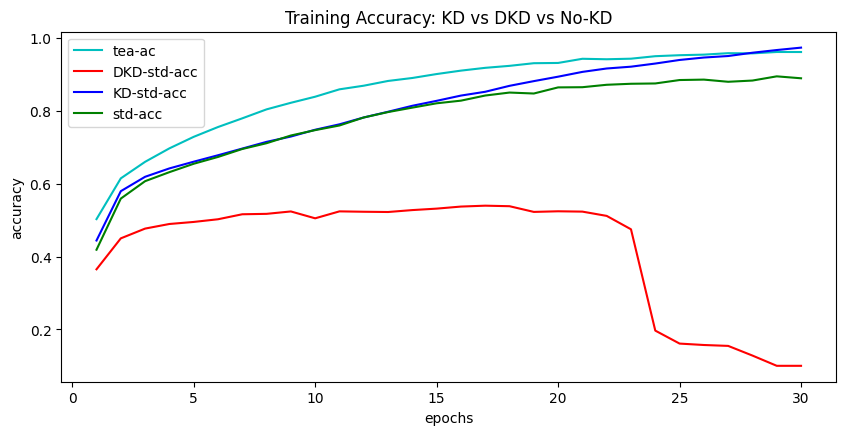

In [42]:
import matplotlib.pyplot as plt

"""

  You have to plot two graphs, one for loss of training and validation data 
  and second one for accuarcy of training and validation data.              
  Set x-axis to number of epochs and y-axis to loss or accuracy. Set legend 
  equal to training and validation set.                                      

"""
legend = ['tea-ac', 'DKD-std-acc', 'KD-std-acc', 'std-acc']
#############################################################################
# PLACE YOUR CODE HERE                                                      #
#############################################################################
epochs = 30
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(range(1, epochs+1), teacher_accuracy, 'c', label='tea-acc')
plt.plot(range(1, epochs+1), train_dkd_accuracy, 'r', label='DKD-std-acc')
plt.plot(range(1, epochs+1), train_kd_accuracy, 'b', label='KD-std-acc')
plt.plot(range(1, epochs+1), train_std_accuracy, 'g', label='std-acc')
plt.title('Training Accuracy: KD vs DKD vs No-KD')
plt.xlabel('epochs')
plt.ylabel('accuracy')

#############################################################################
plt.legend(legend, loc='upper left')
plt.show()


In [43]:
student_val_accuracy = [t for t in std_val_accs]
KDstudent_val_accuracy = [t for t in KD_std_val_accs]
DKDstudent_val_accuracy = [t for t in dkd_std_val_accs]


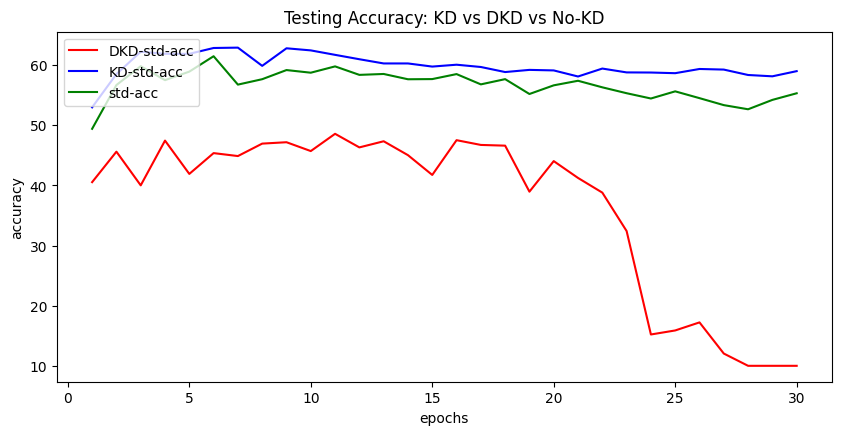

In [44]:
import matplotlib.pyplot as plt

"""

  You have to plot two graphs, one for loss of training and validation data 
  and second one for accuarcy of training and validation data.              
  Set x-axis to number of epochs and y-axis to loss or accuracy. Set legend 
  equal to training and validation set.                                      

"""
legend = ['DKD-std-acc', 'KD-std-acc', 'std-acc']
#############################################################################
# PLACE YOUR CODE HERE                                                      #
#############################################################################
epochs = 30
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(range(1, epochs+1), DKDstudent_val_accuracy, 'r', label='DKD-std-acc')
plt.plot(range(1, epochs+1), KDstudent_val_accuracy, 'b', label='KD-std-acc')
plt.plot(range(1, epochs+1), student_val_accuracy, 'g', label='std-acc')
plt.title('Testing Accuracy: KD vs DKD vs No-KD')
plt.xlabel('epochs')
plt.ylabel('accuracy')

#############################################################################
plt.legend(legend, loc='upper left')
plt.show()
